In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# read in the data
accept_df = pd.read_csv('accept_behavior.csv')
app_df = pd.read_csv('app_behavior.csv')
nurse_df = pd.read_csv('nurse_info.csv')

In [3]:
# format timestamps to 'datetime' 
accept_df['accept_time'] = pd.to_datetime(accept_df['shift_time'])
app_df['sessionDate'] = pd.to_datetime(app_df['sessionDate'])
nurse_df['first_accept_timestamp'] = pd.to_datetime(nurse_df['first_accept_timestamp'])
nurse_df['first_shift_timestamp'] = pd.to_datetime(nurse_df['first_shift_timestamp'])
nurse_df['fifth_shift_timestamp'] = pd.to_datetime(nurse_df['fifth_shift_timestamp'])
nurse_df['termination_timestamp'] = pd.to_datetime(nurse_df['termination_timestamp'])

# clean up some timestamps, engineer some other variables
app_df['sessionDay'] = app_df['sessionDate'].dt.date

In [4]:
# summarize data in app_df at the pid level. what are some interesting features we could build to describe each pid?
app_aggregates = app_df.groupby('pid').agg({'sessionDate':['min','max','count'], 'viewedShifts':['sum', 'mean', 'median'], 'clickedShifts':['sum', 'mean', 'median'], 'sessionDay':['nunique']})

# engineer some features - this is the fun part! what else can you imagine
app_aggregates['days_between_first_and_last_app_open'] = (app_aggregates[('sessionDate', 'max')] - app_aggregates[('sessionDate', 'min')]).astype('timedelta64[D]') + 1
app_aggregates['browsing_session_per_day'] = app_aggregates[('sessionDate', 'count')]/(app_aggregates['days_between_first_and_last_app_open'])
app_aggregates['clicks_per_view'] = app_aggregates[('clickedShifts', 'sum')]/app_aggregates[('viewedShifts', 'sum')]
app_aggregates['daily_engagement_rate'] = app_aggregates[('sessionDay', 'nunique')]/app_aggregates['days_between_first_and_last_app_open']
app_aggregates['clicks_per_session'] = app_aggregates[('clickedShifts', 'mean')]
app_aggregates['lifetime_clicks'] = app_aggregates[('clickedShifts', 'sum')]
app_aggregates['lifetime_sessions'] = app_aggregates[('sessionDate', 'count')]

# only take the variables we want moving forward
app_aggregates = app_aggregates[['days_between_first_and_last_app_open', 'browsing_session_per_day', 'clicks_per_view', 'daily_engagement_rate', 'clicks_per_session', 'lifetime_clicks', 'lifetime_sessions']]
app_aggregates.columns = ['days_between_first_and_last_app_open', 'browsing_session_per_day', 'clicks_per_view', 'daily_engagement_rate', 'clicks_per_session', 'lifetime_clicks', 'lifetime_sessions']
app_aggregates.head()

,days_between_first_and_last_app_open,browsing_session_per_day,clicks_per_view,daily_engagement_rate,clicks_per_session,lifetime_clicks,lifetime_sessions
pid,,,,,,,
0,99.0,19.272727,0.000000,1.000000,0.000000,0,1908
54,98.0,3.500000,0.015272,0.591837,0.212828,73,343
161,92.0,1.847826,0.012129,0.597826,0.288235,49,170
463,75.0,13.040000,0.015568,0.946667,0.261759,256,978
646,1.0,1.000000,0.000000,1.000000,0.000000,0,1


kmeans_label                                          0            1
Prior Work History (distinct jobs)   count  5707.000000  1138.000000
                                     mean      0.000597    -0.002736
                                     50%      -0.295355    -0.295355
Prior Work History (years)           count  5707.000000  1138.000000
                                     mean     -0.017227     0.079284
                                     50%      -1.908414    -1.908414
browsing_session_per_day             count  5707.000000  1138.000000
                                     mean     -1.676125     8.409283
                                     50%      -2.408707     6.554786
clicks_per_session                   count  5707.000000  1138.000000
                                     mean      0.000873    -0.004667
                                     50%      -0.029412    -0.036215
clicks_per_view                      count  5707.000000  1138.000000
                                  

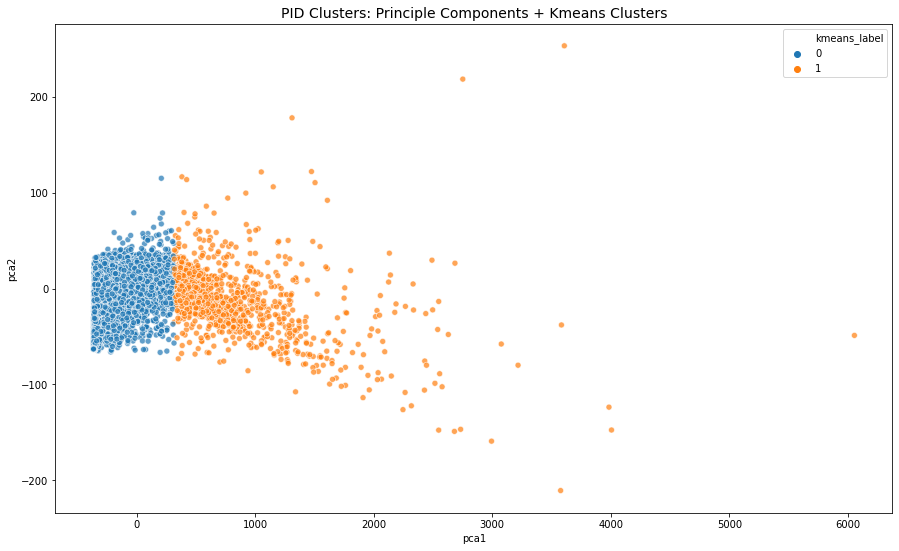

In [7]:
feature_df = nurse_df[['pid', 'Prior Work History (years)', 'Prior Work History (distinct jobs)']]
feature_df = feature_df.merge(app_aggregates, left_on='pid', right_index=True)
feature_df.set_index('pid', inplace=True)
feature_df.fillna(0, inplace=True)
feature_df.head()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA likes to have "centered" data
feature_df = feature_df - feature_df.mean()

# reduce dimensionality - you can use more than 2 dimensions, but it's obviously easier to plot 2 dimensions. 
# PCA is one method to reduce dimensionality but there are many other methods to try. 
reduced_data = PCA(n_components=2).fit_transform(feature_df)

# make clusters using reduced data - kmeans is an easy starting spot but there are many other algorithms to try
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# put cluster labels and PCA coordinates back with our original features
feature_df['pca1'] = reduced_data[:, 0]
feature_df['pca2'] = reduced_data[:, 1]
feature_df['kmeans_label'] = kmeans.predict(reduced_data)

# one pid is a crazy outlier, drop it for now
feature_df = feature_df[feature_df['pca2'] < 4000] 
feature_df.head()
# make a pretty picture - do our clusters pass the eye test?
fig, ax = plt.subplots(1,1, figsize=(15,9))
sns.scatterplot(data=feature_df, x="pca1", y="pca2", hue="kmeans_label", ax=ax, alpha=.7)
ax.set_title('PID Clusters: Principle Components + Kmeans Clusters', fontsize=14)
# number test - what behaviors do our clusters seem to segment?
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(feature_df.groupby('kmeans_label').describe().loc[:,(slice(None),['count','mean', '50%'])].T)